This tutorial will show how to use and modify the data generator pack for Tacton.
Data objects that are relevant for this project are:
C_data - Combination data, 
D_data - Discount data, 
p_data - probability data, 
deal_data - Quote outcome. 
For more information regarding the algorithms behind the data generator: 
https://docs.google.com/document/d/10QUrTwTu61wxq57S-zQgsrRc2BtC6QuKa8mXj4Q4f84/edit

In [1]:
import numpy as np
from matplotlib import pylab as plt
from generate_cpq_data_class import *
import psutil


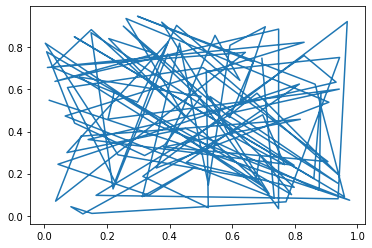

In [2]:
plt.plot(np.random.rand(101),np.random.rand(101))


In [3]:
print("virtual memory used: ", psutil.virtual_memory()[2], "%")


virtual memory used:  48.0 %


The Generator_pack creates a C-gen (Combinations/dimensions-generator), D_gen (Discount-generator), a P (Probability function) and a corresponding P_gen (Probability-generator).

We start this tutortial by initiate a Generator_pack G. discount_max, discount_min, discount_mean, discount_std are parameters for the distribution of the discount data (truncated normal distribution). mean_p and max_p are parameters for the probability distribution. 

In [4]:
G=Generator_pack(discount_max = 0.4, discount_min=0, discount_mean = 0.15, discount_std = 0.2, mean_p = 0.2,
                  max_p = 0.4)



To generate C-data, D-data, p_data and deal_data from the Generator_pack G we just call G.generate_data()

In [11]:
C_train, D_train, p_train, deal_train = G.generate_data(copyfunction=lambda: int(np.maximum(0,np.random.normal(100,0.2))))


Generated data:  611297 / 611297


In [6]:
#print("C_data shape: ", C_data.shape)
#print("D_data shape: ", D_data.shape)
#print("p_data shape: ", p_data.shape)
#print("deal_data shape: ", deal_data.shape)

In [12]:
import numpy as np
from matplotlib import pylab as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

In [26]:
negloglik = lambda y, p_y: -p_y.log_prob(y)
eps = 0.000001
input_shape = (30,)
C = tf.keras.layers.Input(shape=input_shape)
dis = tf.keras.layers.Input(shape=(1,))

k_ = tf.keras.layers.Dense(2,name='k_layer')(C)
m_ = tf.keras.layers.Dense(2,name='m_layer')(C)
z = tf.keras.layers.Lambda(lambda x: x[0]*x[1] - x[2],name='zlayer')([k_,dis,m_])
#z2 = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x))(z2)
y = tf.keras.layers.Dense(1, name='y-layer')(z)
#y = tf.keras.layers.Dense(1)(y)

Out = tfp.layers.DistributionLambda(lambda t: tfd.Bernoulli(probs=(1.0-eps)/(1. + tf.exp(-t) + eps/2)))(y)

model = tf.keras.models.Model(inputs=[dis,C], outputs=Out)
k_model = tf.keras.models.Model(inputs=C, outputs=k_)
m_model = tf.keras.models.Model(inputs=C, outputs=m_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01, decay=1e-4), loss=negloglik, metrics=['mae'])

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
k_layer (Dense)                 (None, 2)            62          input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
m_layer (Dense)                 (None, 2)            62          input_15[0][0]                   
___________________________________________________________________________________________

In [ ]:
model.fit([D_train,C_train], deal_train, batch_size=100, epochs=3, verbose=True)


Train on 611297 samples
Epoch 1/3


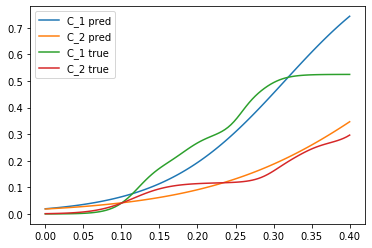

In [20]:

nr=101
dl = np.linspace(0,0.4,nr)
C_1 = one_hot([1,1,1,1,1,1])
C_1_list = np.tile(np.expand_dims(np.array(C_1),0),(nr,1))
p_pred = model([np.expand_dims(dl,1),C_1_list]).mean()
p_pred = np.squeeze(p_pred)
plt.plot(dl,p_pred,label='C_1 pred')

C_2 = one_hot([2,0,0,3,8,2])
C_2_list = np.tile(np.expand_dims(np.array(C_2),0),(nr,1))
p_pred2 = model([np.expand_dims(dl,1),C_2_list]).mean()
p_pred2 = np.squeeze(p_pred2)
plt.plot(dl,p_pred2,label='C_2 pred')


true_C_1_p = lambda d: np.float64(G.P.base_func(to_scalar([1,1,1,1,1,1]), d))
true_p = true_C_1_p(dl)
plt.plot(dl,true_p, label='C_1 true')

true_C_2_p = lambda d: np.float64(G.P.base_func(to_scalar([2,0,0,3,8,2]), d))
true_p2 = true_C_2_p(dl)
plt.plot(dl,true_p2, label='C_2 true')

plt.legend()
plt.show()
